In [1]:
import json, glob, pandas as pd, numpy as np, matplotlib.pyplot as plt

In [2]:
pd.set_option('display.precision', 3)

In [3]:
BENCHMARK_SIZE = 1000

In [4]:
def unilateral_performance(df):
    model_evals = df.groupby('model_name')['evaluation'].value_counts().unstack(fill_value=0)
    model_evals["correct (t)"] = model_evals["t"] / float(BENCHMARK_SIZE)
    model_evals["not attempted (n)"] = model_evals["n"] / float(BENCHMARK_SIZE)
    model_evals["incorrect (f)"] = model_evals["f"] / float(BENCHMARK_SIZE)
    model_evals["correct given attempted"] = model_evals["t"] / (model_evals["t"] + model_evals["f"])
    model_evals["F score"] = (2.*model_evals["t"]) / ((2.*model_evals["t"]) + (2.*model_evals["f"]) + model_evals["n"])
    model_evals = model_evals.sort_values("correct given attempted", ascending=False)
    return model_evals[["t", "n", "f", "correct (t)", "not attempted (n)", "incorrect (f)", "correct given attempted"]]

In [5]:
def bilateral_performance(df):
    model_evals = df.groupby('model_name')['evaluation'].value_counts().unstack(fill_value=0)
    model_evals["correct (t)"] = model_evals["t"] / float(BENCHMARK_SIZE)
    model_evals["inconsistent (b)"] = model_evals["b"] / float(BENCHMARK_SIZE)
    model_evals["unknown (n)"] = model_evals["n"] / float(BENCHMARK_SIZE)
    model_evals["incorrect (f)"] = model_evals["f"] / float(BENCHMARK_SIZE)
    model_evals["not attempted (b+n)"] = (model_evals["b"] + model_evals["n"]) / float(BENCHMARK_SIZE)
    model_evals["correct given attempted"] = model_evals["t"] / (model_evals["t"] + model_evals["f"])
    model_evals["F score"] = (2.*model_evals["t"]) / ((2.*model_evals["t"]) + (2.*model_evals["f"]) + (model_evals["b"] + model_evals["n"]))
    model_evals = model_evals.sort_values("correct given attempted", ascending=False)
    return model_evals[["t", "n", "b", "f", "correct (t)", "unknown (n)", "inconsistent (b)", "incorrect (f)", "correct given attempted"]]

In [6]:
def plot_factuality_comparison(df_unilateral, df_bilateral, figsize=(12, 6)):
    """
    Create a bar plot comparing unilateral and bilateral factuality scores.
    
    Parameters:
    -----------
    df_unilateral : pandas.DataFrame
        DataFrame containing unilateral evaluation results
    df_bilateral : pandas.DataFrame
        DataFrame containing bilateral evaluation results
    figsize : tuple
        Figure size in inches (width, height)
    """
    
    # Get all unique models from the indices
    all_models = pd.concat([
        pd.Series(df_unilateral.index),
        pd.Series(df_bilateral.index)
    ]).unique()
    
    # Prepare data
    uni_scores = []
    bi_scores = []
    
    for model in all_models:
        # Get unilateral score
        try:
            uni_score = df_unilateral.loc[model, 'correct given attempted']
            uni_scores.append(uni_score)
        except KeyError:
            uni_scores.append(np.nan)
        
        # Get bilateral score
        try:
            bi_score = df_bilateral.loc[model, 'correct given attempted']
            bi_scores.append(bi_score)
        except KeyError:
            bi_scores.append(np.nan)
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set the width of each bar and positions of the bars
    width = 0.35
    x = np.arange(len(all_models))
    
    # Create the bars
    rects1 = ax.bar(x - width/2, uni_scores, width, label='Unilateral', color='#8884d8', alpha=0.8)
    rects2 = ax.bar(x + width/2, bi_scores, width, label='Bilateral', color='#82ca9d', alpha=0.8)
    
    # Customize the plot
    ax.set_ylabel('Precision (percentage correct given attempted)')
    ax.set_title(f'Precision of Unilateral vs Bilateral Factuality Evaluation by Model (N={BENCHMARK_SIZE:d})')
    ax.set_xticks(x)
    ax.set_ylim(0, 1.0)
    
    # Format model names for better readability
    model_names = [name.replace('mistralai/', '').replace('-20241022', '') for name in all_models]
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    
    # Add legend
    ax.legend()
    
    # Add value labels on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            if not np.isnan(height):
                ax.annotate(f'{height:.3f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom', rotation=0)
    
    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig, ax

In [7]:
def plot_risk_coverage(df_unilateral, df_bilateral, figsize=(10, 8)):
    """
    Create a risk-coverage scatter plot comparing models across unilateral and bilateral evaluations.
    
    Risk is calculated as:
        error rate = incorrect / (correct + incorrect)
    
    Coverage is calculated as:
        Unilateral: (t + f) / (t + f + n)
        Bilateral: (t + f) / (t + f + b + n)
    
    Parameters:
    -----------
    df_unilateral : pandas.DataFrame
        DataFrame containing unilateral evaluation results
    df_bilateral : pandas.DataFrame
        DataFrame containing bilateral evaluation results
    figsize : tuple
        Figure size in inches (width, height)
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate metrics for unilateral
    risk_uni = df_unilateral['incorrect (f)'] / (df_unilateral['correct (t)'] + df_unilateral['incorrect (f)'])
    coverage_uni = (df_unilateral['correct (t)'] + df_unilateral['incorrect (f)']) / \
                  (df_unilateral['correct (t)'] + df_unilateral['incorrect (f)'] + df_unilateral['not attempted (n)'])
    
    # Calculate metrics for bilateral
    risk_bi = df_bilateral['incorrect (f)'] / (df_bilateral['correct (t)'] + df_bilateral['incorrect (f)'])
    coverage_bi = (df_bilateral['correct (t)'] + df_bilateral['incorrect (f)']) / \
                 (df_bilateral['correct (t)'] + df_bilateral['incorrect (f)'] + \
                  df_bilateral['inconsistent (b)'] + df_bilateral['unknown (n)'])
    
    # Create scatter plots
    uni_scatter = ax.scatter(coverage_uni, risk_uni, 
                           c='#8884d8', s=100, alpha=0.7, 
                           label='Unilateral', marker='o')
    bi_scatter = ax.scatter(coverage_bi, risk_bi, 
                          c='#82ca9d', s=100, alpha=0.7, 
                          label='Bilateral', marker='s')
    
    # Add labels for each point
    def add_labels(x, y, labels, offset=(0.01, 0.01)):
        for i, label in enumerate(labels):
            model_name = label.replace('mistralai/', '').replace('-20241022', '')
            ax.annotate(model_name,
                       (x.iloc[i], y.iloc[i]),
                       xytext=(5, 5),
                       textcoords='offset points',
                       fontsize=8,
                       ha='left')
    
    add_labels(coverage_uni, risk_uni, df_unilateral.index)
    add_labels(coverage_bi, risk_bi, df_bilateral.index)
    
    # Customize the plot
    ax.set_xlabel('Coverage (percentage of examples attempted)')
    ax.set_ylabel('Risk (error rate given attempted)')
    ax.set_title('Risk-Coverage Trade-off of Unilateral vs Bilateral Factuality Evaluation by Model')
    
    # Set axis limits with some padding
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    ax.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

In [8]:
unilateral_results = []
for file in glob.glob("experiments/unilateral/*.json"):
   unilateral_results += json.load(open(file, "r"))
df_unilateral = pd.DataFrame(unilateral_results)
df_unilateral_performance = unilateral_performance(df_unilateral)
df_unilateral_performance

evaluation,t,n,f,correct (t),not attempted (n),incorrect (f),correct given attempted
model_name,,,,,,,
mistralai/Mistral-7B-Instruct-v0.3,845,0,155,0.845,0.000,0.155,0.845
gpt-4o-2024-11-20,715,0,285,0.715,0.000,0.285,0.715
mistralai/Mixtral-8x7B-Instruct-v0.1,611,12,377,0.611,0.012,0.377,0.618
claude-3-5-sonnet-20241022,605,0,395,0.605,0.000,0.395,0.605
gpt-4o-mini,474,2,524,0.474,0.002,0.524,0.475
claude-3-5-haiku-20241022,120,1,879,0.120,0.001,0.879,0.120


In [9]:
bilateral_results = []
for file in glob.glob("experiments/bilateral/*.json"):
   bilateral_results += json.load(open(file, "r"))
df_bilateral = pd.DataFrame(bilateral_results)
df_bilateral_performance = bilateral_performance(df_bilateral)
df_bilateral_performance

evaluation,t,n,b,f,correct (t),unknown (n),inconsistent (b),incorrect (f),correct given attempted
model_name,,,,,,,,,
gpt-4o-mini,547,244,129,80,0.547,0.244,0.129,0.080,0.872
mistralai/Mistral-7B-Instruct-v0.3,590,119,203,88,0.590,0.119,0.203,0.088,0.870
gpt-4o-2024-11-20,335,399,125,141,0.335,0.399,0.125,0.141,0.704
mistralai/Mixtral-8x7B-Instruct-v0.1,340,299,212,149,0.340,0.299,0.212,0.149,0.695
claude-3-5-sonnet-20241022,249,600,36,115,0.249,0.600,0.036,0.115,0.684
claude-3-5-haiku-20241022,234,559,82,125,0.234,0.559,0.082,0.125,0.652


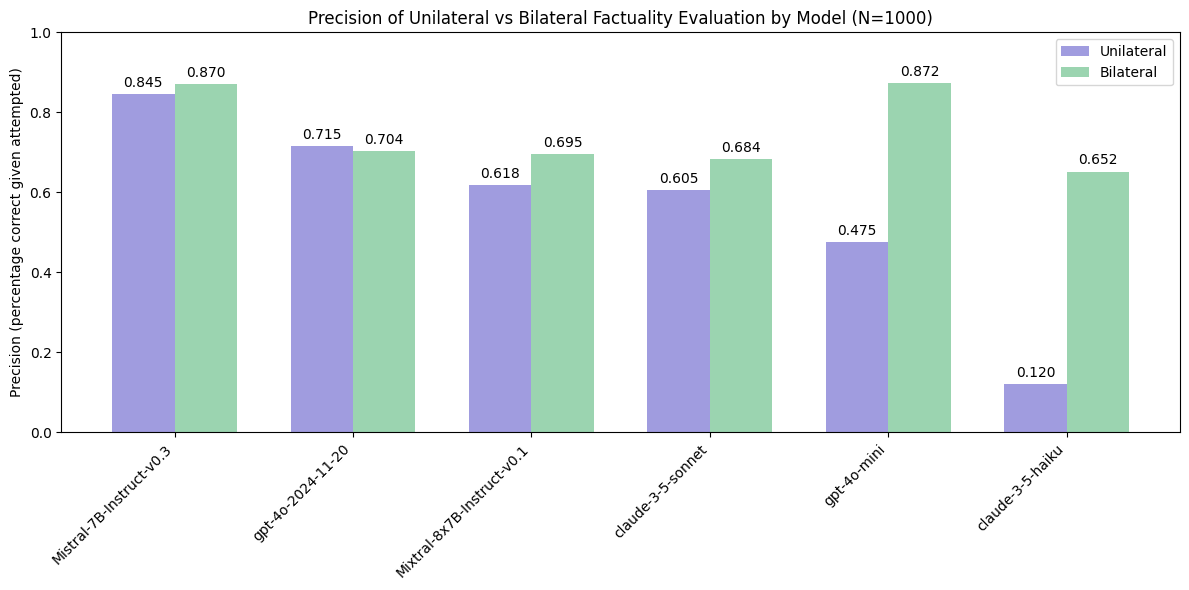

In [10]:
fig, ax = plot_factuality_comparison(df_unilateral_performance, df_bilateral_performance)
plt.show()

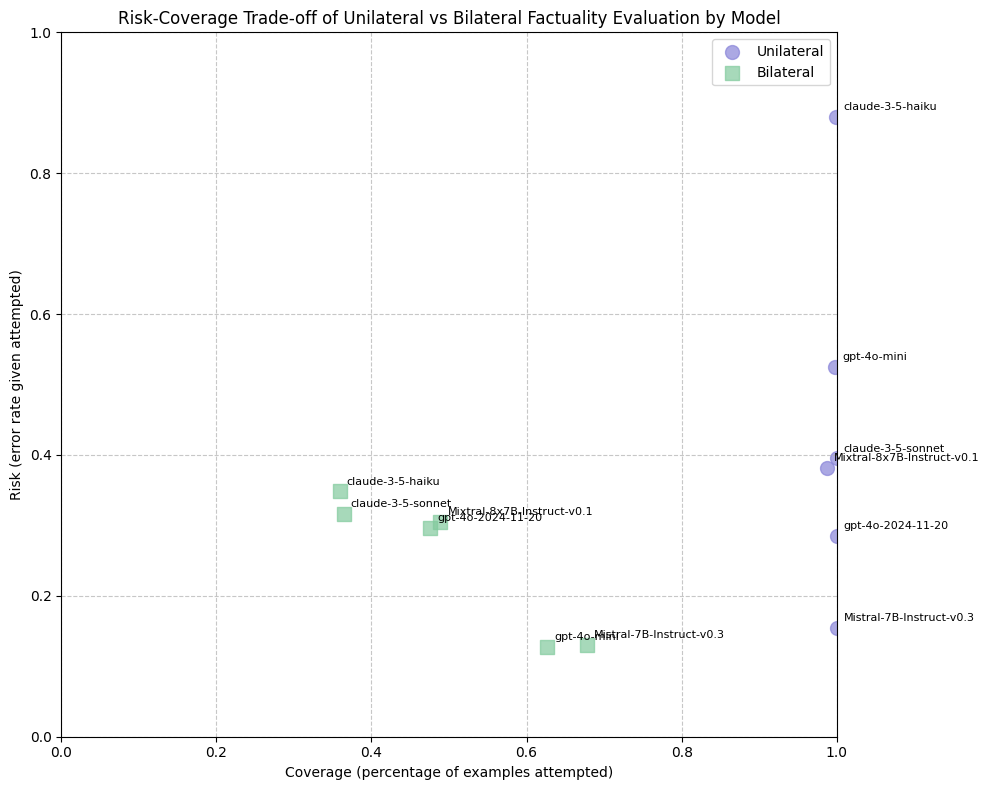

In [11]:
fig, ax = plot_risk_coverage(df_unilateral_performance, df_bilateral_performance)
plt.show()